# Importing Libraries


In [45]:
import numpy as np # For reading and manipulating structured data (like CSV files)
import pandas as pd # For numerical operations and array handling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import label_binarize

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    precision_recall_curve
)


# Loading the Data

In [3]:
df = pd.read_csv('./Dataset/results.csv') #Using pandas to load the data

# Question 1 Dataset description

In [ ]:
#So we are trying to predict  the outcome(win/draw/loss) based on the home team 
#Win-- if home_score > away_score
#Draw-- if scores are equal
#Loss-- if home_score < away_score


# Display the first few rows of the dataset
X = df[['home_team', 'away_team', 'tournament', 'city', 'country', 'neutral']]
y = df['result']
print(df)

# Question 2 Gradient Boosting Classifier

In [ ]:
# Create the classification target
df['result'] = df.apply(
    lambda row: 'Win' if row['home_score'] > row['away_score']
    else 'Loss' if row['home_score'] < row['away_score']
    else 'Draw',
    axis=1
)

# Convert date to datetime and extract year
df['year'] = pd.to_datetime(df['date']).dt.year

# Create home advantage flag (1 = home, 0 = neutral)
df['home_advantage'] = df['neutral'].apply(lambda x: 0 if x else 1)

# Count previous head-to-head matchups (proxy for historical rivalry)
df['matchup'] = df['home_team'] + "_vs_" + df['away_team']
df['matchup_count'] = df.groupby('matchup').cumcount()

# ===================== Select Features and Target =====================
X = df[['home_team', 'away_team', 'tournament', 'home_advantage', 'year', 'matchup_count']]
y = df['result']

# ===================== Preprocessing =====================
cat_features = ['home_team', 'away_team', 'tournament']
num_features = ['home_advantage', 'year', 'matchup_count']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ('num', StandardScaler(), num_features)
])

# ===================== Build Pipeline with SMOTE and Gradient Boosting =====================
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', GradientBoostingClassifier(
        n_estimators=150,
        learning_rate=0.3,
        max_depth=4,
        random_state=42
    ))
])

# ===================== Cross-Validation =====================
scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print(f"Average CV Accuracy: {scores.mean():.4f}")

# Logistic Regression algorithm

In [ ]:
# Create classification target
df['result'] = df.apply(
    lambda row: 'Win' if row['home_score'] > row['away_score']
    else 'Loss' if row['home_score'] < row['away_score']
    else 'Draw',
    axis=1
)

# Feature engineering – only using pre-match data
df['year'] = pd.to_datetime(df['date']).dt.year
df['home_advantage'] = df['neutral'].apply(lambda x: 0 if x else 1)
df['is_final'] = df['tournament'].str.lower().str.contains('final').astype(int)
df['is_friendly'] = df['tournament'].str.lower().str.contains('friendly').astype(int)

#Use only features that are known before the match
X = df[['home_team', 'away_team', 'tournament', 'home_advantage', 'year', 'is_final', 'is_friendly']]
y = df['result']

# Categorical and numeric features
cat_features = ['home_team', 'away_team', 'tournament']
num_features = ['home_advantage', 'year', 'is_final', 'is_friendly']

# Preprocessing: encode categories, scale numbers
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ('num', StandardScaler(), num_features)
])

# Train/test split (stratified to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Build pipeline with Logistic Regression
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        C=0.1,
        verbose=1  # optional: shows training progress
    ))
])

# Fit and evaluate
lr_pipeline.fit(X_train, y_train)
y_pred = lr_pipeline.predict(X_test)

# Report results
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Question 3 Comprehensive Model development Process

In [ ]:
# ======================= 1. DATA CLEANING =======================

# Load dataset
df = pd.read_csv("results.csv")

# Drop rows with essential missing values (cleaning step)
df = df.dropna(subset=['home_team', 'away_team', 'tournament', 'date'])

# Convert date string to datetime object
df['date'] = pd.to_datetime(df['date'])

# ======================= 2. TARGET CREATION =======================

# Create categorical target: 'Win', 'Draw', 'Loss'
df['result'] = df.apply(
    lambda row: 'Win' if row['home_score'] > row['away_score']
    else 'Loss' if row['home_score'] < row['away_score']
    else 'Draw',
    axis=1
)

# ======================= 3. FEATURE ENGINEERING =======================

# Create year feature from date
df['year'] = df['date'].dt.year

# Create home_advantage (1 if not neutral, else 0)
df['home_advantage'] = df['neutral'].apply(lambda x: 0 if x else 1)

# Add binary flags for whether the tournament is a final or friendly
df['is_final'] = df['tournament'].str.lower().str.contains('final').astype(int)
df['is_friendly'] = df['tournament'].str.lower().str.contains('friendly').astype(int)

# ======================= 4. FEATURE SELECTION =======================

# Use only features available *before* the match
X = df[['home_team', 'away_team', 'tournament', 'home_advantage', 'year', 'is_final', 'is_friendly']]
y = df['result']

# ======================= 5. MISSING VALUE HANDLING =======================
# Already done via dropna above. No further imputation needed in this case.

# ======================= 6. ENCODING & SCALING =======================

# Define categorical and numerical columns
cat_features = ['home_team', 'away_team', 'tournament']
num_features = ['home_advantage', 'year', 'is_final', 'is_friendly']

# Apply OneHotEncoder to categorical features, StandardScaler to numeric features
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
    ('num', StandardScaler(), num_features)
])

# ======================= 7. TRAIN-TEST SPLIT =======================

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# ======================= 8. LOGISTIC REGRESSION MODEL =======================

# Build a pipeline: preprocess + Logistic Regression
logistic_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        C=0.1,             # Regularization to reduce overfitting
        random_state=42
    ))
])

# Fit the model to training data
logistic_pipeline.fit(X_train, y_train)

# Predict and evaluate on test data
y_pred_lr = logistic_pipeline.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

# Perform 5-fold cross-validation for robustness
lr_cv_score = cross_val_score(logistic_pipeline, X, y, cv=5, scoring='accuracy')
print("Logistic CV Accuracy:", lr_cv_score.mean())

# ======================= 9. GRADIENT BOOSTING MODEL =======================

# Build a pipeline: preprocess + Gradient Boosting
boosting_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', GradientBoostingClassifier(
        n_estimators=300,       # More trees for better learning
        learning_rate=0.05,     # Slower learning for better generalization
        max_depth=5,            # Moderate tree depth
        random_state=42
    ))
])

# Fit the model
boosting_pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred_gb = boosting_pipeline.predict(X_test)
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Gradient Boosting Report:\n", classification_report(y_test, y_pred_gb))

# Cross-validation to compare generalization
gb_cv_score = cross_val_score(boosting_pipeline, X, y, cv=5, scoring='accuracy')
print("Gradient Boosting CV Accuracy:", gb_cv_score.mean())


# Question 4 Performance Metrics


# 4.1 Evaluate Models

In [49]:
# Predict probabilities (needed for ROC/AUC)
y_proba_lr = logistic_pipeline.predict_proba(X_test)
y_proba_gb = boosting_pipeline.predict_proba(X_test)

# Predict labels
y_pred_lr = logistic_pipeline.predict(X_test)
y_pred_gb = boosting_pipeline.predict(X_test)

# Accuracy
print("Logistic Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))

# Classification Report
print("\nLogistic Classification Report:\n", classification_report(y_test, y_pred_lr))
print("\nGradient Boosting Classification Report:\n", classification_report(y_test, y_pred_gb))


Logistic Accuracy: 0.5734317955526054
Gradient Boosting Accuracy: 0.5360106206438765

Logistic Classification Report:
               precision    recall  f1-score   support

        Draw       0.39      0.04      0.07      2739
        Loss       0.55      0.46      0.50      3402
         Win       0.59      0.88      0.70      5911

    accuracy                           0.57     12052
   macro avg       0.51      0.46      0.43     12052
weighted avg       0.53      0.57      0.50     12052


Gradient Boosting Classification Report:
               precision    recall  f1-score   support

        Draw       0.34      0.02      0.04      2739
        Loss       0.62      0.23      0.33      3402
         Win       0.53      0.95      0.68      5911

    accuracy                           0.54     12052
   macro avg       0.50      0.40      0.35     12052
weighted avg       0.51      0.54      0.44     12052



# 4.2 Confusion Matrix

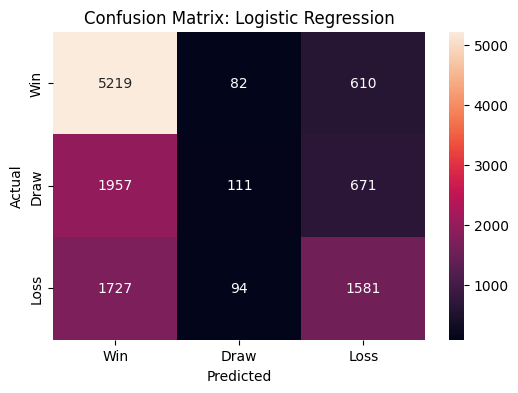

c:\Users\leemi\My Doc\School\Postgraduate\AI Project\ML-Classification-Project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


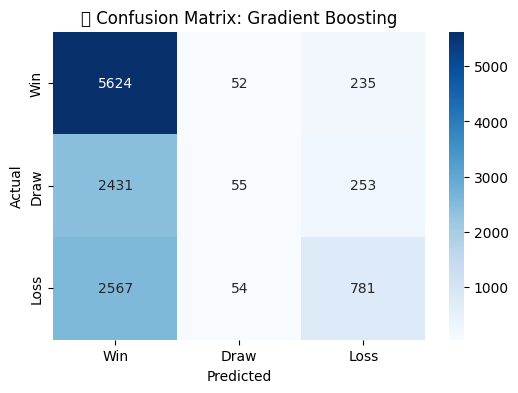

In [50]:
# Confusion Matrix for Logistic
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=['Win', 'Draw', 'Loss'])

plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', xticklabels=['Win', 'Draw', 'Loss'], yticklabels=['Win', 'Draw', 'Loss'])
plt.title("Confusion Matrix: Logistic Regression")
plt.ylabel("Actual"); plt.xlabel("Predicted")
plt.show()


# Generate confusion matrix for Gradient Boosting
cm_gb = confusion_matrix(y_test, y_pred_gb, labels=['Win', 'Draw', 'Loss'])

# Plot it
plt.figure(figsize=(6, 4))
sns.heatmap(cm_gb, annot=True, fmt='d',
            xticklabels=['Win', 'Draw', 'Loss'],
            yticklabels=['Win', 'Draw', 'Loss'],
            cmap='Blues')

plt.title("🌲 Confusion Matrix: Gradient Boosting")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 4.3 ROC Curve (Multiclass using One-vs-Rest)

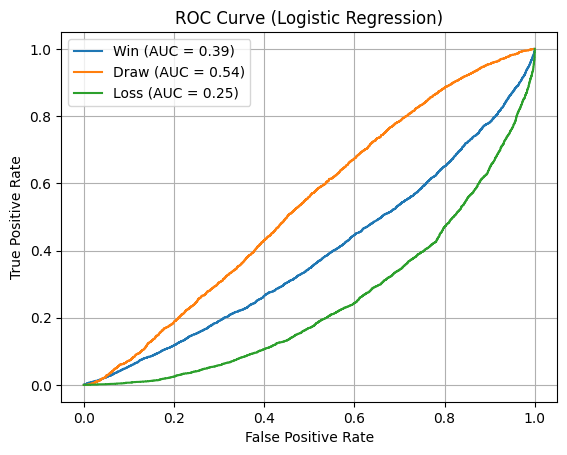

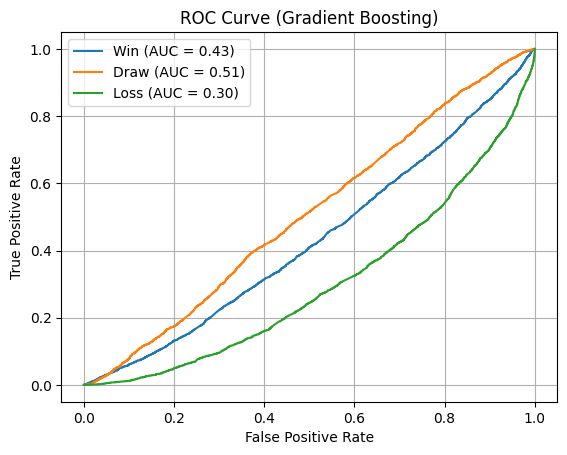

In [51]:

# Binarize the output for ROC for Logistic Regression
classes = ['Win', 'Draw', 'Loss']
y_test_bin = label_binarize(y_test, classes=classes)

# Plot ROC for each class (Logistic)
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_lr[:, i])
    auc = roc_auc_score(y_test_bin[:, i], y_proba_lr[:, i])
    plt.plot(fpr, tpr, label=f"{classes[i]} (AUC = {auc:.2f})")

plt.title("ROC Curve (Logistic Regression)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


# Binarize the output for ROC for Gradient Boosting
classes = ['Win', 'Draw', 'Loss']
y_test_bin = label_binarize(y_test, classes=classes)

# Plot ROC Curve for each class using Gradient Boosting
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_gb[:, i])  # y_proba_gb: probabilities from GB
    auc = roc_auc_score(y_test_bin[:, i], y_proba_gb[:, i])
    plt.plot(fpr, tpr, label=f"{classes[i]} (AUC = {auc:.2f})")

plt.title("ROC Curve (Gradient Boosting)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


# 4.4 Precision-Recall Curve

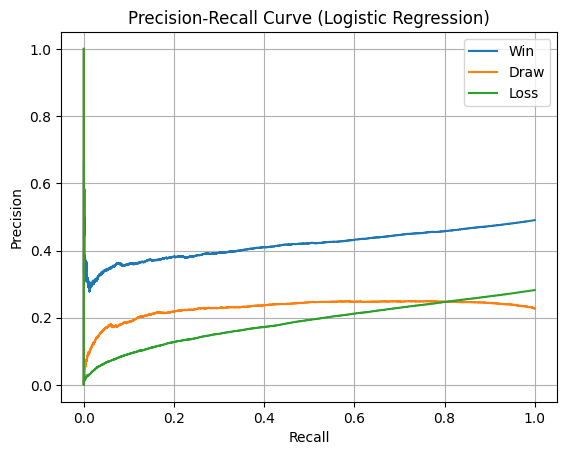

In [52]:
# Defining the classes
classes = ['Win', 'Draw', 'Loss']

# Plot Precision-Recall Curve for each class (Logistic)
for i in range(len(classes)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba_lr[:, i])
    plt.plot(recall, precision, label=f"{classes[i]}")

plt.title("Precision-Recall Curve (Logistic Regression)")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()
